In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as datetime

## Data Cleaning + Wrangling

In [3]:
towerseasons = pd.read_csv('tower_seasons_2019-11-21.csv', parse_dates=['max_canopy_date'])
towerweekly = pd.read_csv('tower_weekly_2019-11-22.csv', parse_dates=['date'])
towers = pd.read_csv('towers_2019-11-21.csv', parse_dates = ['installed_at'])

In [4]:
# Drop NAs
towerseasons_clean = towerseasons.dropna()
towerweekly_clean = towerweekly.dropna().copy()
towers_clean = towers.dropna()

In [5]:
towers_clean.head(1)

,tower_id,crop,metacrop,betweenrowft,slope,aspect,region,subregion,installed_at,young_plant,trellis_type
0,4068,grape,vine,5.0,4,85,NCoast,napa,2019-04-03 18:42:35,True,vsp


In [6]:
towerseasons_clean.head(2)

,tower_id,year,actual_max_canopy,max_canopy_date
2,3512,2019,0.458826,2019-07-08
13,825,2019,0.659543,2019-07-01


In [7]:
# Convert year to datetime
towerweekly_clean['year'] = pd.DatetimeIndex(towerweekly_clean['date']).year
towerweekly_clean.head()

,tower_id,date,irrigation_mm,actual_precip_mm,pri,year
0,10,2019-01-07,0.0,14.204270,1.183220,2019
1,10,2019-01-14,0.0,85.758867,1.158736,2019
2,10,2019-01-21,0.0,0.000000,1.063871,2019
3,10,2019-01-28,0.0,43.022252,1.088352,2019
4,10,2019-02-04,0.0,19.813417,1.166881,2019


In [8]:
## Identifying PRI and max canopy values that don't match and filtering them out. Major cleaning step

In [9]:
# Step 1 - Narrow down to columns of interest
towerweekly_group_pri_clean= towerweekly_clean[['year', 'tower_id', 'pri']]
# towerweekly_group_pri_clean.head()

In [10]:
# Step 2 - Merge previous dataframe with tower_seasons 
tower_pri_comb = towerseasons_clean.merge(towerweekly_group_pri_clean, on =['tower_id', 'year'])
# tower_pri_comb.head()

In [11]:
# Step 3 - Create a new column 'different' which calculates difference between max canopy and PRI
# Remember we want values that are NOT different aka the difference should equal 0 
tower_pri_comb['different'] = tower_pri_comb.actual_max_canopy - tower_pri_comb.pri
# tower_pri_comb.head()

In [12]:
# Step 5 - How many cases did NOT equal 0?
len(tower_pri_comb[tower_pri_comb['different'] != 0 ])

31345

In [13]:
# Step 6 - More importantly, how many cases did equal 0? Almost 600, which is about what we expected.
len(tower_pri_comb[tower_pri_comb['different'] == 0 ])

594

In [14]:
# Step 7 - This is your new dataframe 
trimmed_tower_weekly = tower_pri_comb[tower_pri_comb['different'] == 0 ].copy()
trimmed_tower_weekly.head()

,tower_id,year,actual_max_canopy,max_canopy_date,pri,different
26,3512,2019,0.458826,2019-07-08,0.458826,0.0
89,2048,2019,0.660164,2019-06-17,0.660164,0.0
187,832,2019,0.515444,2019-07-08,0.515444,0.0
205,4230,2019,0.580303,2019-07-08,0.580303,0.0
319,2305,2019,0.701330,2019-06-10,0.701330,0.0


In [15]:
# Step 8 - Do the same exact thing but add the other variables back in.
# Not deleting previous one because of paranoia and fear of losing it.
towerweekly_group_pri_clean_complete = towerweekly_clean[['year', 'tower_id', 'pri', 'irrigation_mm', 'actual_precip_mm', 'date']]
tower_pri_comb_complete = towerseasons_clean.merge(towerweekly_group_pri_clean_complete, on =['tower_id', 'year'])
tower_pri_comb_complete['different'] = tower_pri_comb_complete.actual_max_canopy - tower_pri_comb_complete.pri
len(tower_pri_comb_complete[tower_pri_comb_complete['different'] != 0 ])
len(tower_pri_comb_complete[tower_pri_comb_complete['different'] == 0 ])
trimmed_tower_weekly_complete = tower_pri_comb_complete[tower_pri_comb_complete['different'] == 0 ].copy()
trimmed_tower_weekly.head()
len(trimmed_tower_weekly)

594

In [16]:
# Groupby statement for relevant stats
towerweekly_group = trimmed_tower_weekly.groupby(['year', 'tower_id']).mean()
towerweekly_group.head()

actual_max_canopy       pri  different
year tower_id                                        
2019 10                 0.500498  0.500498        0.0
     18                 0.768882  0.768882        0.0
     20                 0.813847  0.813847        0.0
     21                 0.559340  0.559340        0.0
     27                 0.693847  0.693847        0.0

In [17]:
# Lets merge our data to create one dataframe

In [18]:
print("Towers dimensions: {}".format(trimmed_tower_weekly_complete.shape))
print("Towers Weekly: {}".format(towerseasons_clean.shape))
print("Towers Seasonal: {}".format(towers_clean.shape))

Towers dimensions: (594, 9)
Towers Weekly: (4361, 4)
Towers Seasonal: (1242, 11)


In [19]:
trimmed_tower_weekly_complete.head(2)

,tower_id,year,actual_max_canopy,max_canopy_date,pri,irrigation_mm,actual_precip_mm,date,different
26,3512,2019,0.458826,2019-07-08,0.458826,0.000000,0.0,2019-07-08,0.0
89,2048,2019,0.660164,2019-06-17,0.660164,2.020265,0.0,2019-06-17,0.0


In [20]:
# Merge previous table with towers on tower_id
# Is a fairly small data frame. Something to consider. 
final_table = pd.merge(trimmed_tower_weekly_complete, towers_clean, on = 'tower_id')
print("Towers Seasonal: {}".format(final_table.shape))

Towers Seasonal: (377, 19)


## Analysis Method 1:

### Possibility 1: Take final_table dataset, convert max_canopy_date to day in year (0-364) and then perform a regression with other features to predict the day of year. Convert this number back to a date. 

In [21]:
# Get day of year for date values
final_table['dayofyear'] = final_table['max_canopy_date'].dt.dayofyear
final_table.head(2)

,tower_id,year,actual_max_canopy,max_canopy_date,pri,irrigation_mm,actual_precip_mm,date,different,crop,metacrop,betweenrowft,slope,aspect,region,subregion,installed_at,young_plant,trellis_type,dayofyear
0,3512,2019,0.458826,2019-07-08,0.458826,0.000000,0.0,2019-07-08,0.0,grape,vine,7.0,2,198,NCoast,carneros,2018-06-07 22:24:00,False,quad,189
1,2048,2019,0.660164,2019-06-17,0.660164,2.020265,0.0,2019-06-17,0.0,grape,vine,8.0,1,206,CCoast,pasorobles,2017-03-09 19:09:41,True,vsp,168


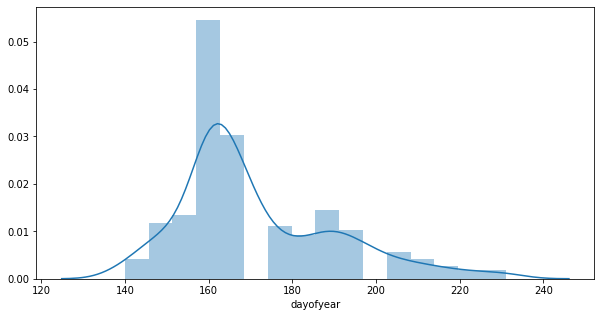

In [68]:
# Regression analysis:
plt.figure(figsize=(10,5))
plt.tight_layout()
sns.distplot(final_table['dayofyear'])
plt.show()

In [23]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [24]:
y = pd.DataFrame(final_table, columns= ['dayofyear'])
y = y['dayofyear']

# How can I add categorical data to this model?
X = pd.DataFrame(final_table, columns = ['actual_max_canopy', 'irrigation_mm', 'actual_precip_mm',
                                         'betweenrowft', 'slope', 'aspect'])

In [25]:
X = pd.DataFrame(final_table, columns = ['actual_max_canopy','tower_id', 'crop', 'metacrop', 'region', 'subregion',
                                         'irrigation_mm', 'actual_precip_mm',
                                         'betweenrowft', 'slope', 'aspect'])

# Get dummy variables for categorical data:
X2 = pd.get_dummies(X, columns= ['crop', 'metacrop', 'region', 'subregion'])

In [26]:
regressor = LinearRegression()  
regressor.fit(X2, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
r_sq = regressor.score(X2, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.24603196000344377


In [28]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

136.6204350817715
[ 7.36783416e+00  1.75744641e-03  1.46109317e-01 -6.98557955e+00
  1.10363029e+00 -1.97473384e-01  4.57490261e-03  4.28074458e+00
 -9.04621715e+00  4.76547257e+00 -9.04621715e+00  9.04621715e+00
 -6.38528482e-01 -4.18182559e-01 -4.12331486e-01  1.46904253e+00
  2.02384914e+01  1.85839211e+01 -2.42953690e+00 -8.07527959e-01
 -1.41013839e+01 -1.84844644e+00  3.84123684e+00 -5.64302875e+00
  3.31748897e+00 -7.28734459e-02  2.55256480e+00 -1.60591122e+01
 -1.78835896e+01  8.29459060e+00  2.01720542e+00]


In [29]:
y_pred = regressor.predict(X2)

In [30]:
coeff_df = pd.DataFrame(regressor.coef_, X2.columns, columns=['Coefficient'])  
coeff_df
# For a unit increase in dayofyear aka one day we will see an increase in the actual max canopy and a decrease in
# actual precipitation, irrigation and slope. 

,Coefficient
actual_max_canopy,7.367834
tower_id,0.001757
irrigation_mm,0.146109
actual_precip_mm,-6.985580
betweenrowft,1.103630
slope,-0.197473
aspect,0.004575
crop_grape,4.280745
crop_pistachio,-9.046217
crop_table_grape,4.765473


In [31]:
df = pd.DataFrame({'Actual': y, 'Predicted': y_pred})
df

,Actual,Predicted
0,189,187.556707
1,168,161.998244
2,189,184.330936
3,189,190.747808
4,161,163.648593
...,...,...
372,168,172.681677
373,161,173.864284
374,168,166.840322
375,175,168.177659


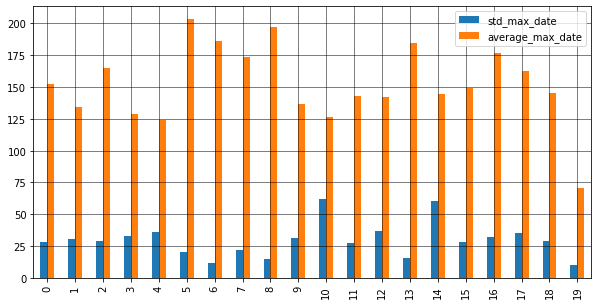

In [66]:
df1 = df.head(50)
df1.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [33]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 12.535737820820623
Mean Squared Error: 269.11322914547395
Root Mean Squared Error: 16.40467095511135


## Data Visualization

In [34]:
## Violin Plot of Actual Max Canopy from towerseasons cleaned df

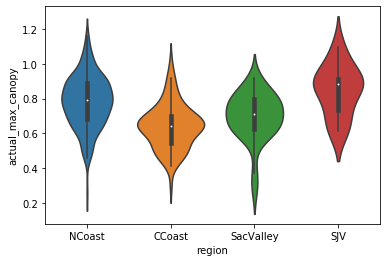

In [35]:
sns.violinplot(x='region', y='actual_max_canopy', data=final_table)

Text(0, 0.5, 'Actual Max Canopy')

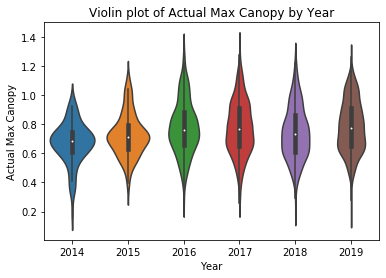

In [36]:
sns.violinplot(x='year', y='actual_max_canopy', data=towerseasons_clean)
plt.title('Violin plot of Actual Max Canopy by Year')
plt.xlabel('Year')
plt.ylabel('Actual Max Canopy')

In [37]:
# Strip plot of Actual Max Canopy by Year

Text(0, 0.5, 'Actual Max Canopy')

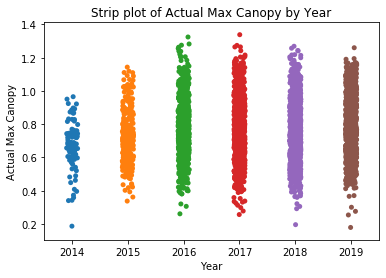

In [38]:
sns.stripplot(x='year', y='actual_max_canopy', data=towerseasons_clean, jitter=True)
plt.title('Strip plot of Actual Max Canopy by Year')
plt.xlabel('Year')
plt.ylabel('Actual Max Canopy')

In [39]:
## Violin Plot of Actual Max Canopy from towerseasons cleaned df using count data

Text(0, 0.5, 'Actual Max Canopy')

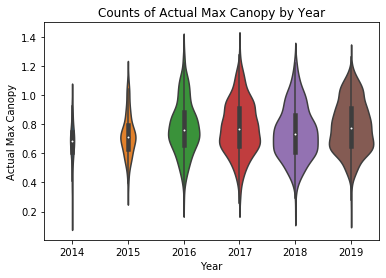

In [40]:
sns.violinplot(x='year', y='actual_max_canopy', data=towerseasons_clean, scale='count')
plt.title('Counts of Actual Max Canopy by Year')
plt.xlabel('Year')
plt.ylabel('Actual Max Canopy')
# Shows number of observations 

Text(0.5, 0, 'PRI')

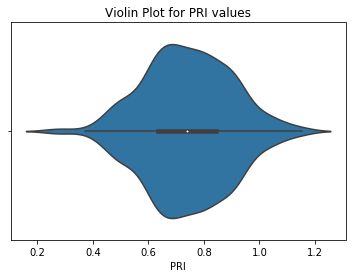

In [41]:
sns.violinplot(x=final_table['pri'])
plt.title('Violin Plot for PRI values')
plt.xlabel('PRI')

In [42]:
# Groupby statement for relevant stats
towerweekly_group = trimmed_tower_weekly.groupby(['year', 'tower_id']).mean()
towerweekly_group.head(5)

actual_max_canopy       pri  different
year tower_id                                        
2019 10                 0.500498  0.500498        0.0
     18                 0.768882  0.768882        0.0
     20                 0.813847  0.813847        0.0
     21                 0.559340  0.559340        0.0
     27                 0.693847  0.693847        0.0

In [43]:
towerweekly_clean.head()
# How to compare each date for each tower because there are 1207 towers
# Tough because there are so many towers and about 33 dates / tower.
# Cleaned data just has 2019 due to missing values in other years.

# Jan 21 meeting w Devin:
# Groupby tower id, crop, pri, weekly dates
# different forecast for each crop
# Which dataset do we want to use for this?

# Feb 4 
# 3 forecasts grape, table grape and pistachio
# 2 columns for each crop
# week number of year as first column, average pri as second column across all years and towers.
# tower weekly data set with crops. 

,tower_id,date,irrigation_mm,actual_precip_mm,pri,year
0,10,2019-01-07,0.0,14.204270,1.183220,2019
1,10,2019-01-14,0.0,85.758867,1.158736,2019
2,10,2019-01-21,0.0,0.000000,1.063871,2019
3,10,2019-01-28,0.0,43.022252,1.088352,2019
4,10,2019-02-04,0.0,19.813417,1.166881,2019


In [44]:
tower_dictionary = {i:j for h,i,j in final_table[['tower_id', 'crop']].itertuples()}

In [45]:
towerweekly_clean['crop'] = towerweekly_clean['tower_id'].apply(lambda x: tower_dictionary[x] if x in tower_dictionary else "")
towerweekly_clean['crop'].unique()

array(['grape', '', 'table_grape', 'pistachio'], dtype=object)

In [118]:
# Converting a date to week of year
towerweekly_clean['week'] = towerweekly_clean['date'].dt.week
towerweekly_clean.head()





,tower_id,date,irrigation_mm,actual_precip_mm,pri,year,crop,week
0,10,2019-01-07,0.0,14.204270,1.183220,2019,grape,2
1,10,2019-01-14,0.0,85.758867,1.158736,2019,grape,3
2,10,2019-01-21,0.0,0.000000,1.063871,2019,grape,4
3,10,2019-01-28,0.0,43.022252,1.088352,2019,grape,5
4,10,2019-02-04,0.0,19.813417,1.166881,2019,grape,6


In [122]:
# Create three new dataframes for grape, table grape and pistachio.
# col1 = week number of year, col2 = average pri across all years and towers.
towerweekly_clean.head()

towerweekly_clean.groupby(by = ['crop', 'tower_id', 'year']).mean()

irrigation_mm  actual_precip_mm       pri  week
crop        tower_id year                                                 
            11       2019       0.040373         28.643572  0.845447  18.0
            13       2019       0.278440         35.770946  0.680209  18.0
            14       2019       0.039500         41.365989  0.976516   8.5
            15       2019       4.010871         10.990815  0.727936  18.0
            16       2019       1.983819         16.680703  0.658404  18.0
...                                  ...               ...       ...   ...
table_grape 4024     2019       9.807772          3.474536  0.769213  20.5
            4136     2019      24.078961          1.988580  0.550082  26.0
            4141     2019      35.701270          2.235294  0.621947  26.0
            4209     2019      79.454610          2.352941  0.792477  26.0
            4224     2019       0.000000          1.776471  0.779789  26.0

[1207 rows x 4 columns]

In [46]:
final_table.head()

,tower_id,year,actual_max_canopy,max_canopy_date,pri,irrigation_mm,actual_precip_mm,date,different,crop,metacrop,betweenrowft,slope,aspect,region,subregion,installed_at,young_plant,trellis_type,dayofyear
0,3512,2019,0.458826,2019-07-08,0.458826,0.000000,0.0,2019-07-08,0.0,grape,vine,7.0,2,198,NCoast,carneros,2018-06-07 22:24:00,False,quad,189
1,2048,2019,0.660164,2019-06-17,0.660164,2.020265,0.0,2019-06-17,0.0,grape,vine,8.0,1,206,CCoast,pasorobles,2017-03-09 19:09:41,True,vsp,168
2,832,2019,0.515444,2019-07-08,0.515444,0.000000,0.0,2019-07-08,0.0,grape,vine,8.0,2,190,NCoast,carneros,2016-03-03 00:25:00,False,vsp,189
3,4230,2019,0.580303,2019-07-08,0.580303,6.047731,0.0,2019-07-08,0.0,grape,vine,8.0,10,335,NCoast,carneros,2019-04-19 18:47:10,False,vsp,189
4,2305,2019,0.701330,2019-06-10,0.701330,0.000000,0.0,2019-06-10,0.0,grape,vine,9.0,1,225,CCoast,pasorobles,2017-04-26 22:30:47,True,vsp,161


## Phase 1

### Merge towers into tower_seasons.
### Convert max_canopy_date to numeric.
### For each tower calculate the years of data (# of instances of a max_canopy_date), average max_canopy_date and the standard deviation of max_canopy_date.

In [47]:
# Phase 1 
# This dataset is best for a more simple statistical approach.
# Looks at historic data, looks at similar sites.
# If no historical data, determines a window for looking for the max canopy using median  + 1 SD.
# Uses tower seasons
towerseasons_clean['year'].unique()

array([2019, 2015, 2017, 2018, 2016, 2014])

In [48]:
towers.head(1)
towers.crop.unique()

array(['grape', nan, 'walnut', 'tomato', 'almond', 'other', 'alfalfa',
       'avocado', 'strawberry', 'prune', 'cotton', 'pistachio', 'wheat',
       'corn', 'citrus', 'sunflower', 'olive', 'melon', 'table_grape',
       'cherry', 'raisin'], dtype=object)

In [49]:
towerseasons.head(10)

,tower_id,year,actual_max_canopy,max_canopy_date
0,5562,2011,NaN,2011-06-22
1,4151,2020,NaN,NaT
2,3512,2019,0.458826,2019-07-08
3,2272,2019,NaN,NaT
4,4949,2012,NaN,2012-06-08
5,5409,2019,NaN,NaT
6,3863,2011,NaN,2011-02-27
7,4214,2019,NaN,NaT
8,4949,2015,NaN,2015-07-18
9,334,2013,NaN,2013-06-26


In [50]:
towerseasons.shape

(14837, 4)

In [51]:
# Merging tower seasons and towers
towers.head()
towerseasons.head()

# Right merge to keep all keys from towerseasons
full_towers = pd.merge(towers, towerseasons, on='tower_id', how='right')
full_towers.head()
full_towers.shape

# Totalling NA values 
full_towers.isna().sum()

tower_id                 0
crop                    35
metacrop                35
betweenrowft            28
slope                   28
aspect                  28
region                  28
subregion               28
installed_at            28
young_plant            212
trellis_type          3582
year                     0
actual_max_canopy    10468
max_canopy_date       1492
dtype: int64

In [74]:
# Totaling clean values
full_towers_clean = full_towers.dropna()
full_towers_clean.head()

,tower_id,crop,metacrop,betweenrowft,slope,aspect,region,subregion,installed_at,young_plant,trellis_type,year,actual_max_canopy,max_canopy_date,dayofyear
4,4068,grape,vine,5.0,4.0,85.0,NCoast,napa,2019-04-03 18:42:35,True,vsp,2019,1.033074,2019-06-17,168.0
9,3490,grape,vine,8.0,0.0,297.0,NCoast,napa,2018-04-19 22:57:42,False,vsp,2018,0.919281,2018-06-25,176.0
11,3490,grape,vine,8.0,0.0,297.0,NCoast,napa,2018-04-19 22:57:42,False,vsp,2019,1.031695,2019-06-24,175.0
19,1297,grape,vine,10.0,1.0,252.0,NCoast,napa,2016-05-20 19:16:29,False,lyre,2019,0.943267,2019-07-08,189.0
22,1297,grape,vine,10.0,1.0,252.0,NCoast,napa,2016-05-20 19:16:29,False,lyre,2016,0.929295,2016-06-05,157.0


In [53]:
# Convert max_canopy_date to numeric
# Now have a new column 'dayofyear' equivalent to the day of year
full_towers['dayofyear'] = full_towers['max_canopy_date'].dt.dayofyear

In [54]:
full_towers_group = full_towers.groupby('tower_id')['max_canopy_date'].count()
full_towers_group.head()

tower_id
5     7
6     6
10    9
11    9
12    5
Name: max_canopy_date, dtype: int64

In [55]:
full_towers_summary =  full_towers.groupby(by='tower_id').agg({'dayofyear': ['count', 'mean', 'std']}).rename(columns={'count': 'yrs_of_data', 'mean': 'average_max_date', 'std':'std_max_date'})
full_towers_summary.head(10)

dayofyear                              
         yrs_of_data average_max_date std_max_date
tower_id                                          
5                  7       174.142857    14.484803
6                  6       150.166667    20.769368
10                 9       172.888889    14.084073
11                 9       187.222222    19.696305
12                 5       182.200000    17.626684
13                 9       181.666667    13.674794
14                 8       195.625000    11.783008
15                 9       160.555556    21.054163
16                 9       167.444444    16.860539
17                 9       179.000000    22.891046

In [56]:
mean = np.mean(full_towers_summary['dayofyear'][['std_max_date']])
mean

std_max_date    21.165978
dtype: float64

In [57]:
full_towers_summary.describe()

dayofyear                              
       yrs_of_data average_max_date std_max_date
count  1815.000000      1745.000000  1596.000000
mean      7.352617       165.697250    21.165978
std       2.715906        22.651970     8.382292
min       0.000000        15.000000     0.000000
25%       7.000000       155.500000    15.395125
50%       9.000000       170.400000    19.679777
75%       9.000000       179.777778    25.751213
max       9.000000       272.000000   159.806133

In [58]:
full_towers_summary_crop =  full_towers.groupby(by=['tower_id', 'crop']).agg({'dayofyear': ['count', 'mean', 'std']}).rename(columns={'count': 'yrs_of_data', 'mean': 'average_max_date', 'std':'std_max_date'})
full_towers_summary_crop.head()

dayofyear                              
               yrs_of_data average_max_date std_max_date
tower_id crop                                           
5        grape           7       174.142857    14.484803
6        grape           6       150.166667    20.769368
10       grape           9       172.888889    14.084073
11       grape           9       187.222222    19.696305
12       grape           5       182.200000    17.626684

In [59]:
full_towers_summary_crop =  full_towers.groupby(by=['crop']).agg({'dayofyear': ['count', 'mean', 'std']}).rename(columns={'count': 'yrs_of_data', 'mean': 'average_max_date', 'std':'std_max_date'})
full_towers_summary_crop.head(2)

dayofyear                              
        yrs_of_data average_max_date std_max_date
crop                                             
alfalfa          42       152.166667    28.381475
almond         1492       134.136059    30.949120

### Plotting Average Max Canopy Date with Standard Deviation for each crop

In [60]:
# Notes
#    3 points average max date, average max date - SD and ave max date + SD
#    Into a new data frame.
#    Two graphs overlayed
#    Y axis Crop, X axis scale from 0 to 365 
#    First graph - line graph for each crop max date - SD with a line to the max date + SD
#    Same axes and same scale, scatter plot, points are average max date.

# Reorganize values of interest into a dataframe for plotting.

In [61]:
# Create new dataframe for plotting.
ave_max_date = full_towers_summary_crop['dayofyear'][['average_max_date']]
ave_max_date = ave_max_date['average_max_date']
ave_max_date = ave_max_date.reset_index(drop = 'True')
s1 = pd.Series(ave_max_date)

crop = full_towers_summary_crop['dayofyear'][['std_max_date']]
std_max_date = crop['std_max_date']
a = std_max_date.reset_index()
# std_max_date2 = test.reset_index(drop = 'True')
# s2 = pd.Series(std_max_date2)

df = pd.concat([a,s1], axis = 1)

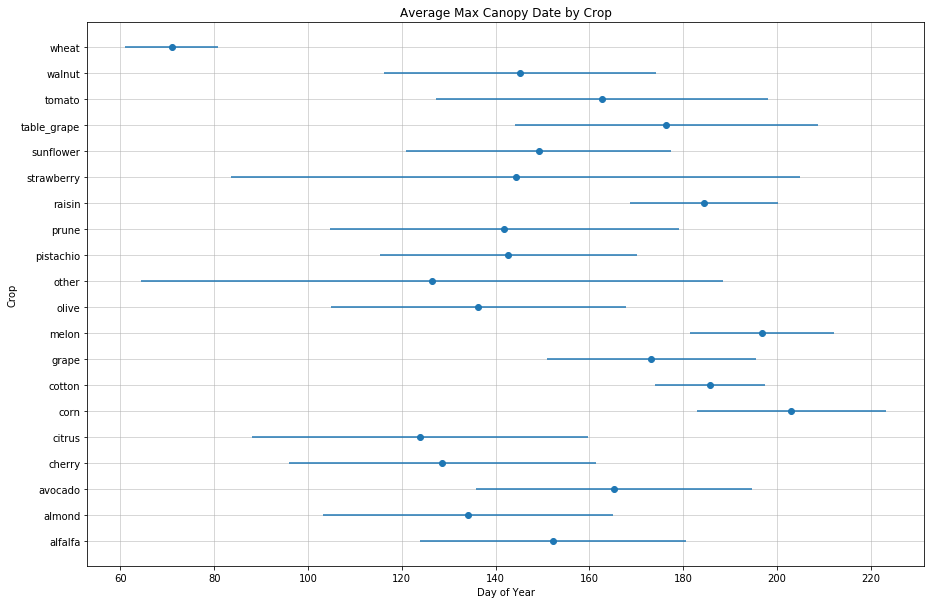

In [71]:
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.errorbar(df.average_max_date, df.crop, xerr=df.std_max_date, fmt='o')
plt.xlabel("Day of Year")
plt.ylabel("Crop")
plt.title("Average Max Canopy Date by Crop")
plt.grid(True, which = "both",linewidth = .5)
plt.show()

In [430]:
# Build the plot
# fig, ax = plt.subplots()
# ax.bar(x_pos, df.average_max_date, yerr=df.std_max_date, align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('Crop')
# ax.set_xticks(x_pos)
# ax.set_xticklabels(df.crop)
# ax.set_title('Max Canopy Date Windows')
# ax.yaxis.grid(True)

# # Save the figure and show
# plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
# plt.show()